<a href="https://colab.research.google.com/github/KaiWoessner/NFLDataAnalysis/blob/main/NFLTeamRankings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
# Install the library for NFL Data
!pip install nfl_data_py
import nfl_data_py as nfl

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
# Import Play By Play Dataset
pbp = nfl.import_pbp_data([2023], downcast=True)
pbp = pbp[pbp["season_type"] =='REG']
pbp2023 = pbp[pbp["season"] == 2023]

2023 done.
Downcasting floats.


In [127]:
# TEAM WEEKLY DATA
pbp_week = pbp2023[pbp2023["play_type"].isin(["pass", "run"])].reset_index(drop=True)

results = []

for column in ["posteam", "defteam"]:

  play_per_week = pbp_week.groupby([column, "week"]).size().reset_index()
  play_per_week = play_per_week.rename(columns={0: "play_count"})

  epa_week = pbp_week.groupby([column, "week"])["epa"].sum().reset_index()

  epa_week["epa_per_play"] = epa_week["epa"] / play_per_week["play_count"]

  epa_weeks = []

  for week in range(1, max(epa_week["week"])+1):
      epa_week_temp = epa_week[epa_week["week"] == week].reset_index(drop=True)
      if (column == "posteam"):
        epa_week_temp = epa_week_temp.sort_values(by="epa_per_play", ascending=False).reset_index(drop=True)
      else:
        epa_week_temp = epa_week_temp.sort_values(by="epa_per_play", ascending=True).reset_index(drop=True)
      epa_week_temp['rank'] = range(1, len(epa_week_temp)+1)
      epa_weeks.append(epa_week_temp)

  epa_weeks = pd.concat(epa_weeks, axis=0).reset_index(drop=True)

  results.append((column, epa_weeks))

# Split into offense and defense
week_posteam_data = results[0][1]
week_defteam_data = results[1][1]

In [128]:
def weekly_ranking(data, side, title):
  # CREATE CHART
  logo_images = []

  for team in data[side]:
      logo_img = Image.open(f'/content/drive/My Drive/NFL_AbrevLogos/{team}.png')  # Adjust the path to your logo images
      logo_images.append(logo_img)


  plt.figure(figsize=(14, 10))

  fig, ax = plt.subplots(figsize=(8, 10))

  # Arrow Legends
  plt.arrow(19, 4, 0, 57, width = 0.1, color = "k")
  plt.text(19, 63, 'Best', ha='center')
  plt.text(19, 2, 'Worst', ha='center')

  # Scatter plot with markers replaced by logos
  for i in range(len(data.index)):
      x, y = data["week"][i] , data["rank"][i]*2

      # Overlay the logo at each data point
      logo_img = logo_images[i]
      plt.imshow(logo_img, extent=[x-0.45, x+0.45, (abs(64-y)+2)-1, (abs(64-y)+2)+1], aspect='auto', zorder=3)

  plt.title("Weekly " + f'{title}' + " Performance in 2023")
  plt.text(0.5, 0.99, 'Rankings based on ' + f'{title}' + ' EPA/Play' , fontsize=10, ha='center', transform=ax.transAxes)

  plt.xlabel('Week')
  plt.ylabel('')
  plt.grid(True)

  plt.xlim(0.5,20)
  plt.xticks(range(1, 19, 1))

  plt.ylim(0, 66)
  plt.yticks([])

  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)
  plt.gca().spines['bottom'].set_visible(False)
  plt.gca().spines['left'].set_visible(False)

  plt.tight_layout()
  plt.show()

<Figure size 1400x1000 with 0 Axes>

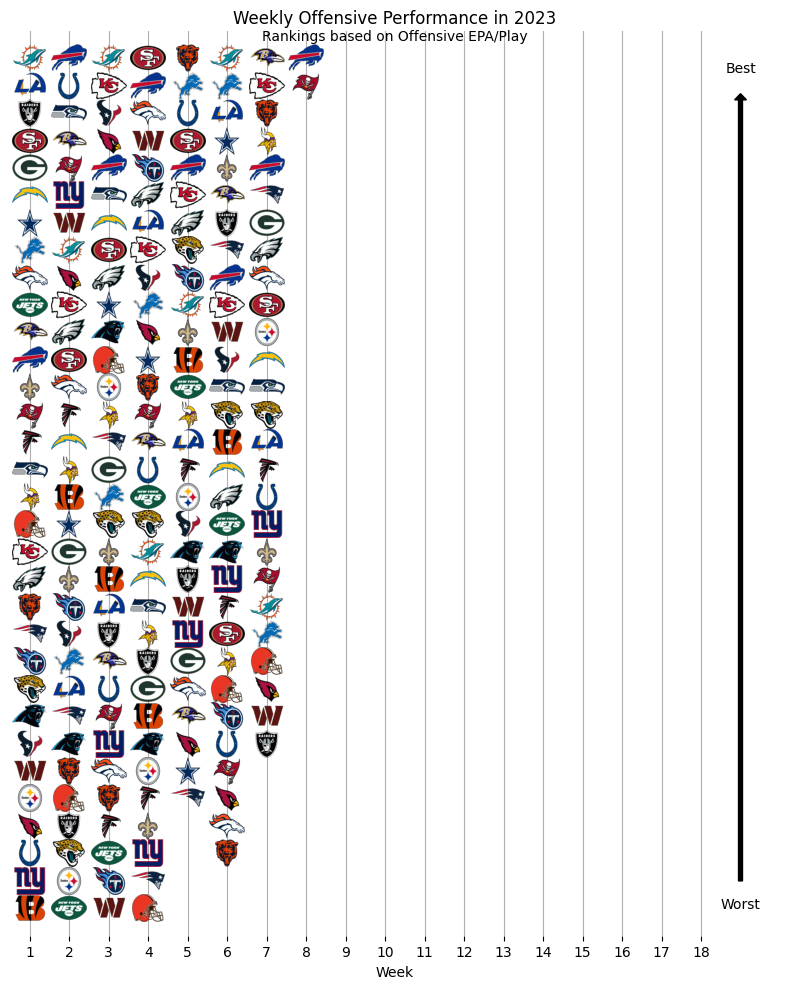

In [129]:
weekly_ranking(week_posteam_data, "posteam", "Offensive")

<Figure size 1400x1000 with 0 Axes>

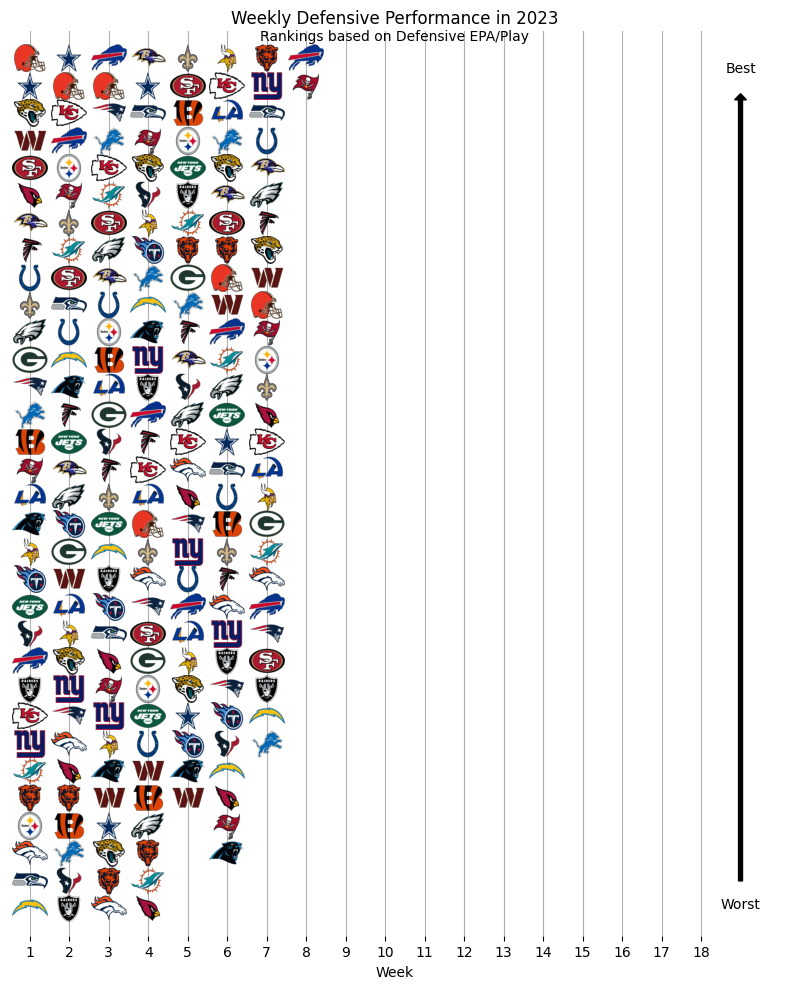

In [130]:
weekly_ranking(week_defteam_data, "defteam", "Defensive")

In [131]:
# TEAM OVERALL DATA
pbp_week = pbp2023[pbp2023["play_type"].isin(["pass", "run"])].reset_index(drop=True)


results = []

for column in ["posteam", "defteam"]:

  play_per_week = pbp_week.groupby([column, "week"]).size().reset_index()
  play_per_week = play_per_week.rename(columns={0: "play_count"})

  epa_week = pbp_week.groupby([column, "week"])["epa"].sum().reset_index()

  epa_week["epa_per_play"] = epa_week["epa"] / play_per_week["play_count"]

  # Sort the data
  epa_week.sort_values(by=[column, 'week'], inplace=True)

  team_mapping = {'Team 1': "ARI", "Team 2": "ATL", "Team 3": "BAL", "Team 4": "BUF", "Team 5": "CAR", "Team 6": "CHI", "Team 7": "CIN", "Team 8": "CLE", "Team 9": "DAL", "Team 10": "DEN",
                    "Team 11": "DET", "Team 12": "GB", "Team 13": "HOU", "Team 14": "IND", "Team 15": "JAX", "Team 16": "KC", "Team 17": "LV", "Team 18": "LAC", "Team 19": "LA", "Team 20": "MIA",
                      "Team 21": "MIN", "Team 22": "NE", "Team 23": "NO", "Team 24": "NYG", "Team 25": "NYJ", "Team 26": "PHI", "Team 27": "PIT", "Team 28": "SF", "Team 29": "SEA", "Team 30": "TB",
                        "Team 31": "TEN", "Team 32": "WAS"}

  # Create Dummy df for bye weeks
  weeks = list(range(1, 8))
  teams = ['Team {}'.format(i) for i in range(1, 33)]
  all_teams = pd.DataFrame([(week, team) for week in weeks for team in teams], columns=['week', column])
  all_teams[column] = all_teams[column].replace(team_mapping)

  # Combine the dfs
  merged_data = all_teams.merge(epa_week, on=['week', column], how='left')
  merged_data['epa_per_play'] = merged_data['epa_per_play'].fillna(0)

  # Create new df for cumulative EPA per play
  cumulative_data = pd.DataFrame()

  # Iterate over unique teams in the DataFrame
  for team in merged_data[column].unique():
      # Filter the data for the current team
      team_data = merged_data[merged_data[column] == team].copy()

      # Initialize a new column
      team_data['cumulative_epa_per_play'] = 0.0

      # Iterate over unique weeks for the current team
      for week in team_data['week'].unique():
          cumulative_epa_per_play = team_data[team_data['week'] <= week]['epa_per_play'].sum()
          team_data.loc[team_data['week'] == week, 'cumulative_epa_per_play'] = cumulative_epa_per_play

      # Add teams data to cumulative_data
      cumulative_data = pd.concat([cumulative_data, team_data], ignore_index=True)

  # Sort the data
  cumulative_data.sort_values(by=[column, 'week'], inplace=True)


  cumulative_data = cumulative_data.sort_values(by=["week",'cumulative_epa_per_play'], ascending=[True, False]).reset_index(drop=True)

  if (column == "posteam"):
    cumulative_data['rank'] = cumulative_data.groupby('week')['cumulative_epa_per_play'].rank(ascending=False)
  else:
    cumulative_data['rank'] = cumulative_data.groupby('week')['cumulative_epa_per_play'].rank(ascending=True)

  # Add datafram to results
  results.append((column, cumulative_data))

# Split into offense and defense
overall_posteam_data = results[0][1]
overall_defteam_data = results[1][1]

In [132]:
def overall_ranking(data, side, title):
  # CREATE CHART
  logo_images = []

  for team in data[side]:
      logo_img = Image.open(f'/content/drive/My Drive/NFL_AbrevLogos/{team}.png')  # Adjust the path to your logo images
      logo_images.append(logo_img)

  fig, ax = plt.subplots(figsize=(8, 10))

  # Arrow Legends
  plt.arrow(19, 4, 0, 57, width = 0.1, color = "k")
  plt.text(19, 63, 'Best', ha='center')
  plt.text(19, 2, 'Worst', ha='center')

  # Scatter plot with markers replaced by logos
  for i in range(len(data.index)):
      x, y = data["week"][i] , data["rank"][i]*2

      # Overlay the logo at each data point
      logo_img = logo_images[i]
      plt.imshow(logo_img, extent=[x-0.45, x+0.45, (abs(64-y)+2)-1, (abs(64-y)+2)+1], aspect='auto', zorder=3)

  plt.title('Overall ' + f"{title}" + ' Ranking by Week in 2023')
  plt.text(0.5, 0.99, 'Rankings based on ' + f"{title}" + ' EPA/Play' , fontsize=10, ha='center', transform=ax.transAxes)

  plt.xlabel('Week')
  plt.ylabel('')
  plt.grid(True)

  plt.xlim(0.5,20)
  plt.xticks(range(1, 19, 1))

  plt.ylim(0, 66)
  plt.yticks([])

  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)
  plt.gca().spines['bottom'].set_visible(False)
  plt.gca().spines['left'].set_visible(False)

  plt.tight_layout()
  plt.show()

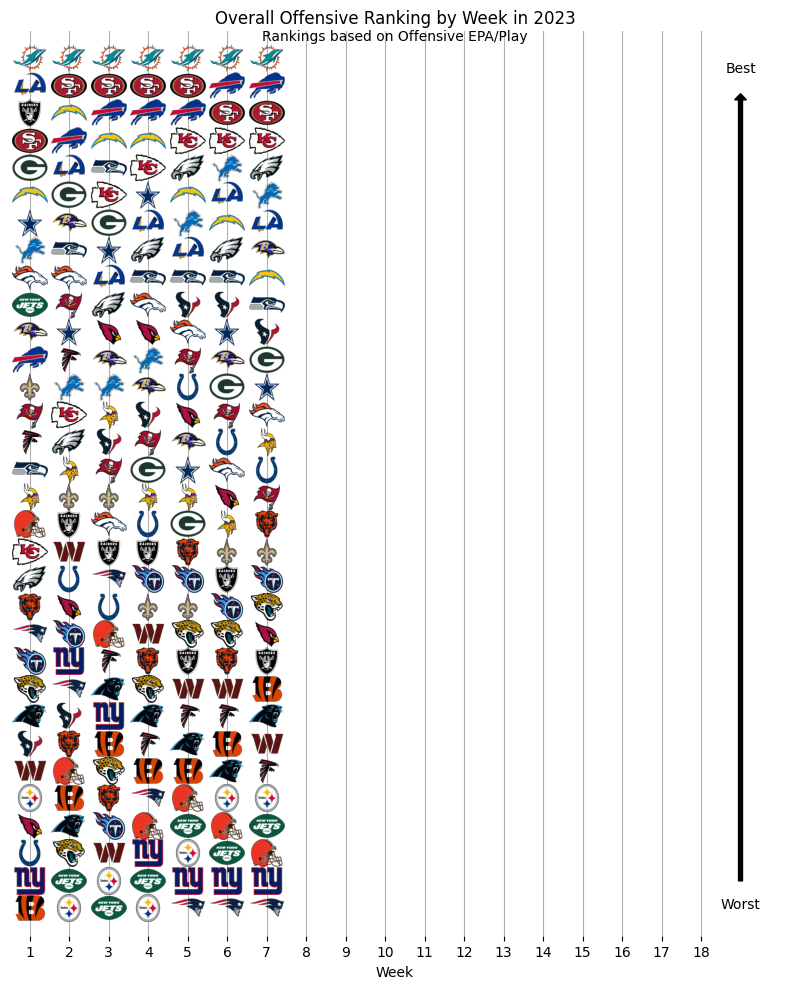

In [133]:
overall_ranking(overall_posteam_data, "posteam", "Offensive")

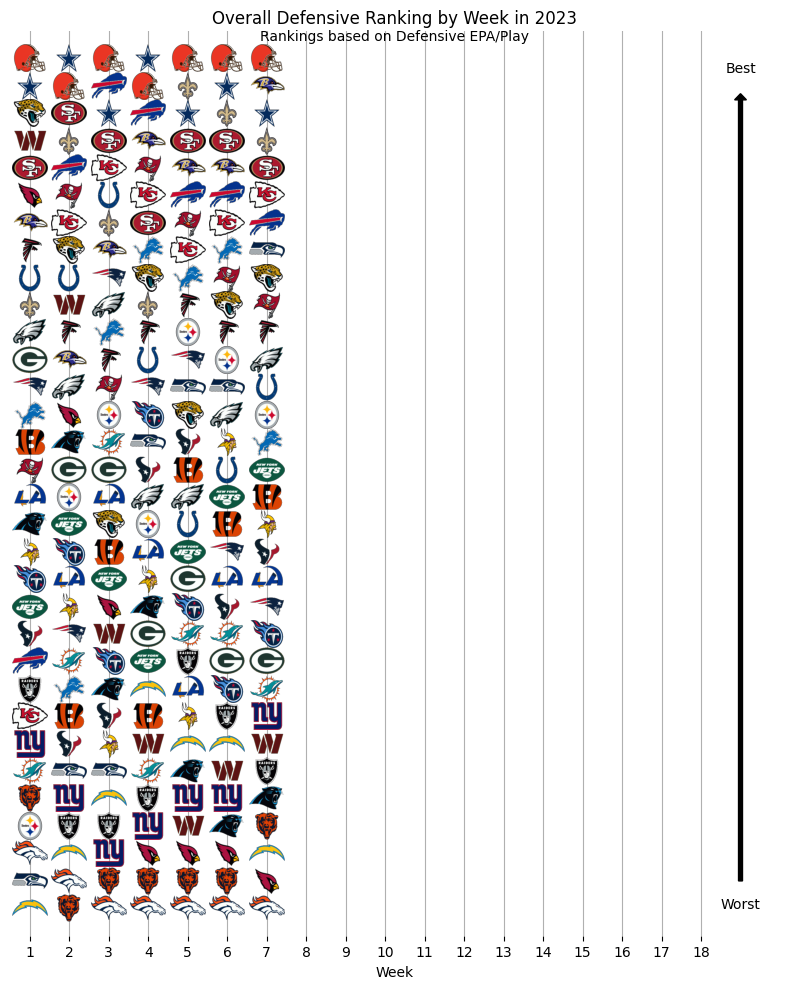

In [134]:
overall_ranking(overall_defteam_data, "defteam", "Defensive")